# LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection

## 1. Overview

The goal here is to detect anomaly from time series data. However, the data does not contain any kind of pattern or trend. We call this kind of data, 'unbalanced'.  
It is nearly impossible to train with unbalanced dataset, either inference. Therefore, we cannot use 'supervised learning' anymore and need to find some alternatives.  
Here, let's review an 'unsupervised learning' methodology published in 2016. The concept is not a state of art, but still powerful.  
Before we dive in to the paper and its implementation, let's first take a look at RNN, LSTM and AutoEncoder as well.  

## 2. RNN

### 2-1. Concept

RNN, Recurrent Neural Network is built for continuously generated (serial) data, such as time series or natural language.  
Limit of DNN comes out when we try to use it to serial data. It is often used to model temporal information.  
It has hidden states as a funciton of inputs and previous time step information. In short, a RNN model can remember the past.

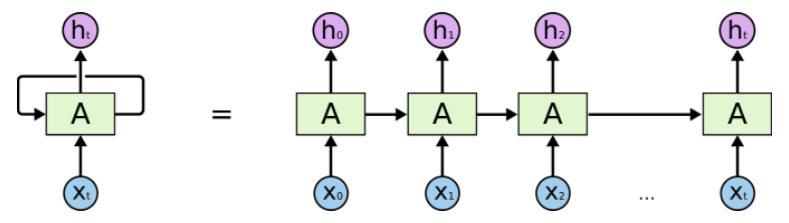

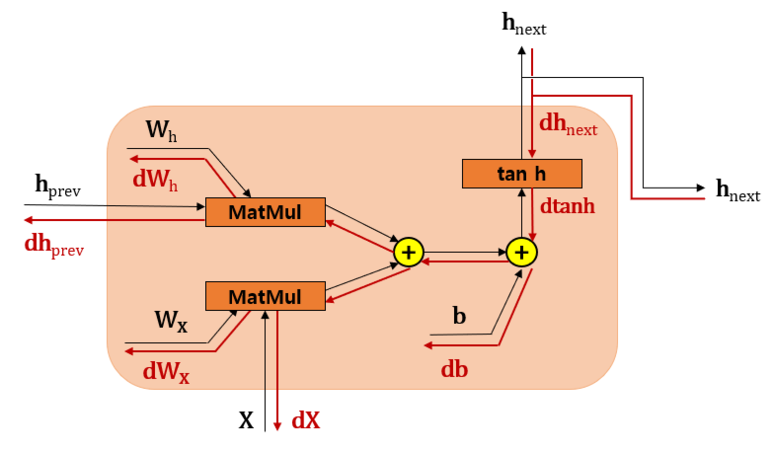

(Vanilla) Recurrent Neural Network  
The state consists of a single “hidden” vector h

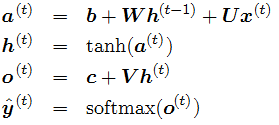

### 2-2. Example: Text RNN

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

Here, we need a corpus for training. For convenience, I set length of each sentence 3.  

In [2]:
sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float

word_list = list(set(" ".join(sentences).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict) # number of distict words in the corpus

print(word_dict)
print(number_dict)

{'dog': 0, 'i': 1, 'love': 2, 'coffee': 3, 'like': 4, 'milk': 5, 'hate': 6, 'you': 7, 'cat': 8}
{0: 'dog', 1: 'i', 2: 'love', 3: 'coffee', 4: 'like', 5: 'milk', 6: 'hate', 7: 'you', 8: 'cat'}


In [3]:
batch_size = len(sentences)
n_step = 2  # length of a sentence for training - 1
n_hidden = 5  # size of hidden layers

def make_batch(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split() # ["i", "like", "dog"]
        input = [word_dict[n] for n in word[:-1]] # [0, 7]
        target = word_dict[word[-1]] # [1]

        input_batch.append(np.eye(n_class)[input])  # One-Hot Encoding
        target_batch.append(target) # [1, 2, 3, 8, 3, 2]
  
    return input_batch, target_batch

input_batch, target_batch = make_batch(sentences)

input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)

RNN class is shown up here. Thanks to PyTorch, we can implement RNN easily.  
Initial weight and bias are torch.randn([n_hidden, n_class]) and torch.randn([n_class]) respectively.

In [4]:
class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
        self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, hidden, X):
        X = X.transpose(0, 1)
        outputs, hidden = self.rnn(X, hidden)
        outputs = outputs[-1]  # Hidden layer: Final prediction
        model = torch.mm(outputs, self.W) + self.b  # Final output layer: Final hidden layer
        return model

With TextRNN() above, here we train the model with the corpus.

In [5]:
model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
    hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
    output = model(hidden, input_batch)
    loss = criterion(output, target_batch)

    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0100 cost = 0.372047
Epoch: 0200 cost = 0.040905
Epoch: 0300 cost = 0.016576
Epoch: 0400 cost = 0.009563
Epoch: 0500 cost = 0.006387


/home/ados/anaconda3/envs/torch191/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [6]:
input = [sen.split()[:2] for sen in sentences]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])

[['i', 'like'], ['i', 'love'], ['i', 'hate'], ['you', 'like'], ['you', 'love'], ['you', 'hate']] -> ['dog', 'coffee', 'milk', 'cat', 'milk', 'coffee']


## 3. LSTM

### 3-1. Concept

One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task,  
such as using previous video frames might inform the understanding of the present frame.  
If RNNs could do this, they’d be extremely useful. But can they? It depends.

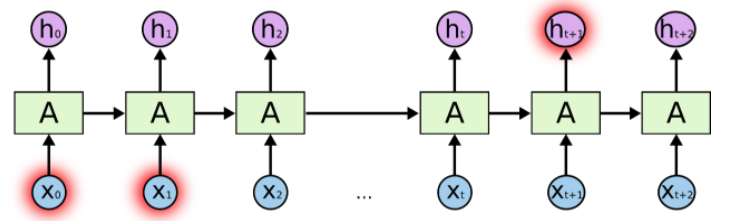

In theory, RNNs are absolutely capable of handling such “long-term dependencies.” A human could carefully pick parameters for them to solve toy problems of this form.  
Sadly, in practice, RNNs don’t seem to be able to learn them.  
The problem was explored in depth by Hochreiter (1991) [German] and Bengio, et al. (1994), who found some pretty fundamental reasons why it might be difficult.  
Thankfully, LSTM(Long Short Term Memory)s don’t have this problem.

The repeating module in a standard RNN contains a single layer is as shown below.

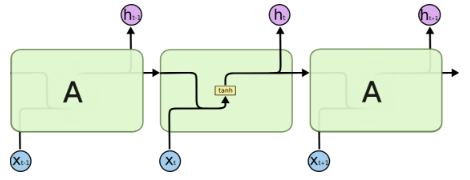

LSTMs also have this chain like structure, but the repeating module has a different structure.  
Instead of having a single neural network layer, there are four, interacting in a very special way.

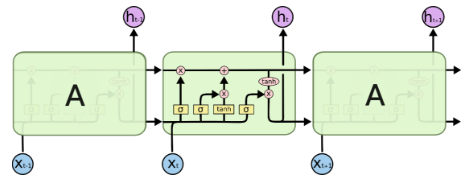

Unlike RNN, we can notice there is another path and this is a memory cell.  
From this cell, LSTM provides memory mechanism and it solves long-term dependency, a.k.a gradient vanishing problem.

### 3-2. Model Description

Now let's carefully observe how LSTM cell is built.

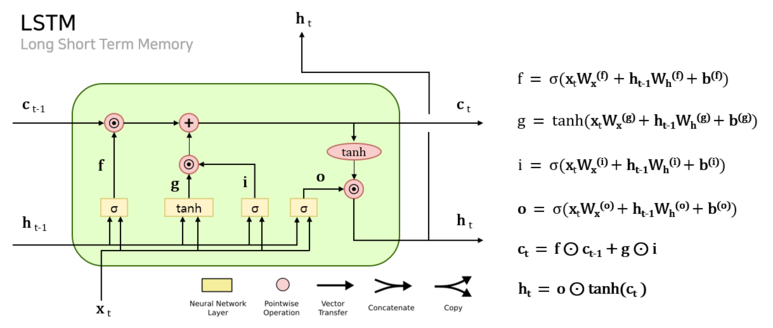

#### Output Gate  
A hidden state h_t is simply tanh(c_t). Therefore, we have to adjust 'how important each element of tanh(c_t) is for the next hideen state h_t+1'.  
An output gate o at time t is given as o_t = sigmoid(W_xo * x_t + W_ho * h_t-1 + b_o)  
h_t = o_t * tanh(c_t) (*: Hardmard product; Element-wise product; Generalization of inner product)  
In RNN, h_t = tanh(W_xh * X_t + W_hh * h_t-1). Hence, we can simply say that LSTM makes an output by applying sigmoid function rather than tanh function and multiplying it with tanh(c_t).

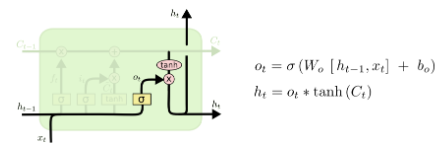

#### Forget Gate  
A model does not have to hold useless information from previous cells. Hence, this sigmoid function instruct which information to 'forget'.  
A forget gate helps current cell forget less important concept in c_t-1

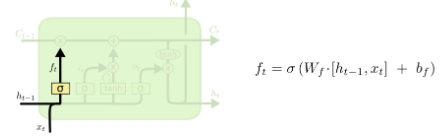

#### Cell Gate  
While going through 'Forget Gate', past information is partially deleted. So we have to feed present data into the cell.  
To do so, we add tanh node. C~_t is the output from this node.  
The reason why we use tanh rather than sigmoid is that, the node is not a gate but it tends to add new data into the memory cell.  
By doing so, past data is partially forgotten and present data is added.

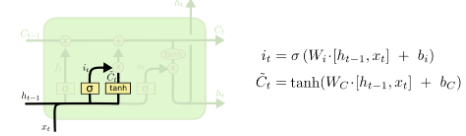

#### Input Gate  
Lastly, we need a gate for the output from the cell gate. From the cell gate, we determined how much of the present information is going to be added.  
Hence, the main function of the input gate is not to take new information without filtering but to selectively append them.

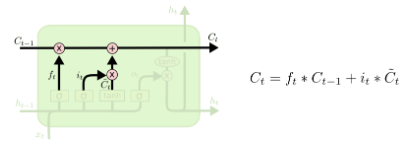

### 3.3 Gradient Flow

So now we fully understand what is actually going on in a LSTM cell. But the main purpose of using it is to prevent gradient vanishing.  
The key is 'Back Propagation of memory cell c'. 

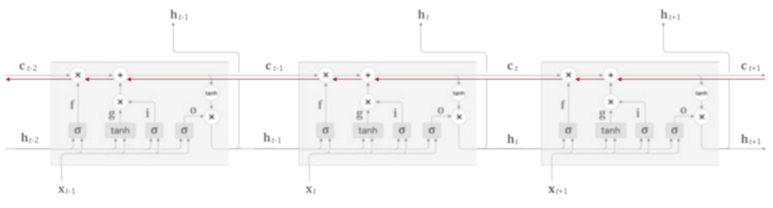

Diagram above shows flow of back propagation in perspective of c. Let's take a glance of the red line at the top.  
While its BP, it passes + and x nodes. But + node does not affect, so only x nodes remain.  
One thing noticable is, x nodes does not compute matrix multiplication. Unlike what RNN does, a LSTM cell conduct Hadamard product instead.  
Secondly, LSTM's c path does not use identical weight matrix all along, but conducts matrix multiplication with newly added information.  
Hence, for every cell, there is a new matrix to be multiplied and this helps a LSTM model not accumulate the effect of matrix multiplication.  
Also, let's look at the x node again. Computation of x node is under control of the forget gate.  
When BP is being calculated, output of forget gate and upper stream gradient are multiplied.  
Therefore, gradient of information, forget gate decided to 'forget' diminishes.  
On the other hand, gradient of information, forget gate decided to 'not forget' does not get any weaker, but propagated backward without minor change.  
Hence, the gradient of important information does not vanish during BP steps.  
By its name, Long Short Term Memory!

### 3.4 Example: Text LSTM

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float

"""
Word Processing
"""
word_list = list(set(" ".join(sentences).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)

In [8]:
"""
TextRNN Parameter
"""
batch_size = len(sentences)
n_step = 2  # 학습 하려고 하는 문장의 길이 - 1
n_hidden = 5  # 은닉층 사이즈

def make_batch(sentences):
  input_batch = []
  target_batch = []

  for sen in sentences:
    word = sen.split()
    input = [word_dict[n] for n in word[:-1]]
    target = word_dict[word[-1]]

    input_batch.append(np.eye(n_class)[input])  # One-Hot Encoding
    target_batch.append(target)
  
  return input_batch, target_batch

input_batch, target_batch = make_batch(sentences)
input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)

In [9]:
"""
TextLSTM
"""
class TextLSTM(nn.Module):
  def __init__(self):
    super(TextLSTM, self).__init__()

    self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
    self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
    self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
    self.Softmax = nn.Softmax(dim=1)

  def forward(self, hidden_and_cell, X):
    X = X.transpose(0, 1)
    outputs, hidden = self.lstm(X, hidden_and_cell)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
    return model

In [10]:
"""
Training
"""
model = TextLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
  hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
  cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
  output = model((hidden, cell), input_batch)
  loss = criterion(output, target_batch)

  if (epoch + 1) % 100 == 0:
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0100 cost = 0.229347
Epoch: 0200 cost = 0.032244
Epoch: 0300 cost = 0.013262
Epoch: 0400 cost = 0.006159
Epoch: 0500 cost = 0.003993


In [11]:
input = [sen.split()[:2] for sen in sentences]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model((hidden, cell), input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])

[['i', 'like'], ['i', 'love'], ['i', 'hate'], ['you', 'like'], ['you', 'love'], ['you', 'hate']] -> ['dog', 'coffee', 'milk', 'cat', 'milk', 'coffee']


## 4. GRU

LSTM solves gradient vanishing problem very smartly and provides good layers for serial, mainly temporal data.  
However, as we have seen above, LSTM requires too many parameters, so too much computation as well.  
As always, scientists find the way. Among those, let's take a look at GRU(Gated Recurrent Unit), proposed by KyeongHyun Cho.

GRU keeps concept of gates in LSTM up, but reduces number of parameters as well as its computing time.  
By comparing their interfaces, we can easily notice the difference; GRU is way simpler.

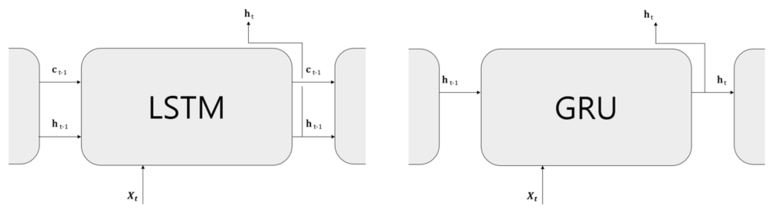

Computation hold in a single cell of GRU is shown as below.

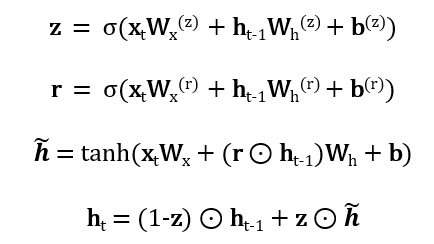

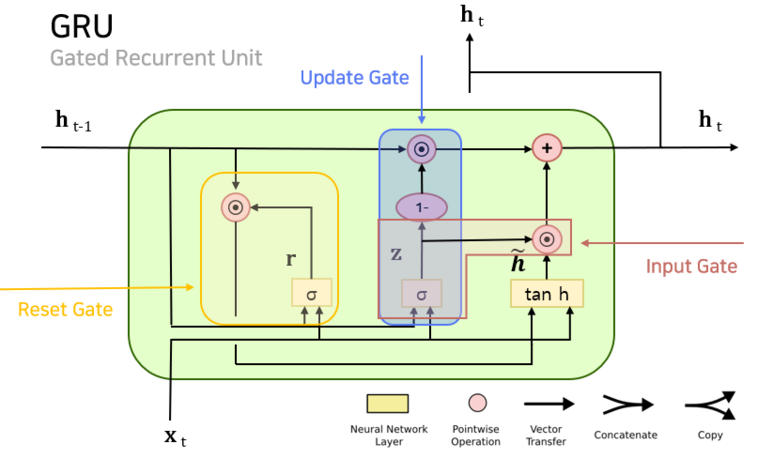

Unlike LSTM, there are no memory cell(cell gate) in GRU. It only has hidden state h_t in forward direction.  
This characteristic is somewhat similar to what we have seen in RNN structure.  
Here in GRU, we use two gates; reset gates 'r', and update gates 'z'.  

Reset gates 'r' determine how much are we going to ignore past hidden state h_t-1.  
If r=0, h~ = tanh(W_x * X_t + W_h * (r * h_t-1) + b). Simply, present cell completely forgets past hidden state.  

On the other hand, update gates 'z' are for update of hidden state. z plays rolls of forget gate and input gate in LSTM alone.  
Function of forget gate is being conducted by (1-z) * h_t-1. This line deletes forget-like past information.  
Function of inpout gate is being conducted by z * h~. This line provides weight to newly added information.

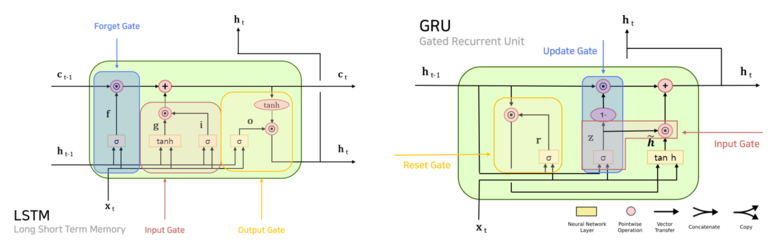

GRU has less parameters and computation. Thus, if dataset is small or many repetition is required during modelling, it might be a better choice.

## 5. LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection

In [12]:
import pandas as pd
import os
import pickle
from celluloid import Camera
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from typing import List
import easydict

### Data Import - sensor.csv

In [13]:
df = pd.read_csv('sensor.csv', index_col=0)
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


  0%|          | 0/52 [00:00<?, ?it/s]

/tmp/ipykernel_398/3642989101.py:38: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  animation.save(


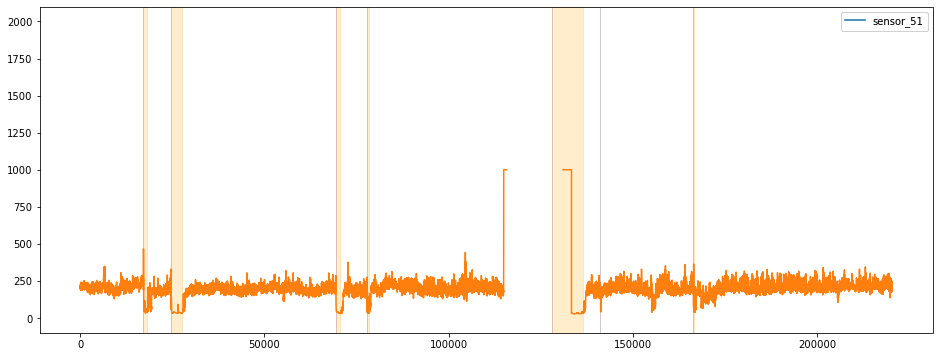

In [14]:
def plot_sensor(temp_df, save_path='sample.gif'):
    fig = plt.figure(figsize=(16, 6))
    ## 에니메이션 만들기
    camera = Camera(fig)
    ax=fig.add_subplot(111)
    
    ## 불량 구간 탐색 데이터
    labels = temp_df['machine_status'].values.tolist()
    dates = temp_df.index
    
    for var_name in tqdm([item for item in df.columns if 'sensor_' in item]):
        temp_df[var_name].plot(ax=ax)
        ax.legend([var_name], loc='upper right')
        
        ## 고장구간 표시
        temp_start = dates[0]
        temp_date = dates[0]
        temp_label = labels[0]
        
        for xc, value in zip(dates, labels):
            if temp_label != value:
                if temp_label == "BROKEN":
                    ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
                if temp_label == "RECOVERING":
                    ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
                temp_start=xc
                temp_label=value
            temp_date = xc
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, xc, alpha=0.2, color='orange')
        ## 카메라 찍기
        camera.snap()
        
    animation = camera.animate(500, blit=True)
    # .gif 파일로 저장하면 끝!
    animation.save(
        save_path,
        dpi=100,
        savefig_kwargs={
            'frameon': False,
            'pad_inches': 'tight'
        }
    )
plot_sensor(df, 'merge.gif')

### Data Preprocesssing

In [15]:
# date column
df['date'] = pd.to_datetime(df['timestamp'])
for var_index in [item for item in df.columns if 'sensor_' in item]:
    df[var_index] = pd.to_numeric(df[var_index], errors='coerce')
del df['timestamp']

# Sort by date and reset index
df = df.set_index('date')
df = df.reset_index()

In [16]:
df.head()

,date,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


<AxesSubplot:>

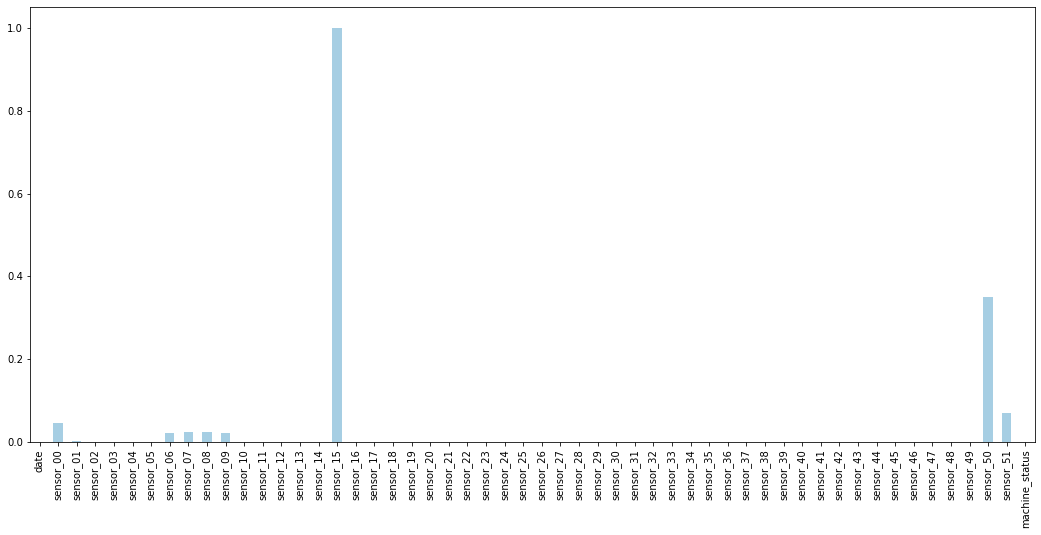

In [17]:
# Null value
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')

In [18]:
df = df.drop_duplicates()

## Delete sensor 15, 50
del df['sensor_15']
del df['sensor_50']

In [19]:
df.head()

,date,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL


In [20]:
# Interpolation with mode
df = df.fillna(0)

<AxesSubplot:>

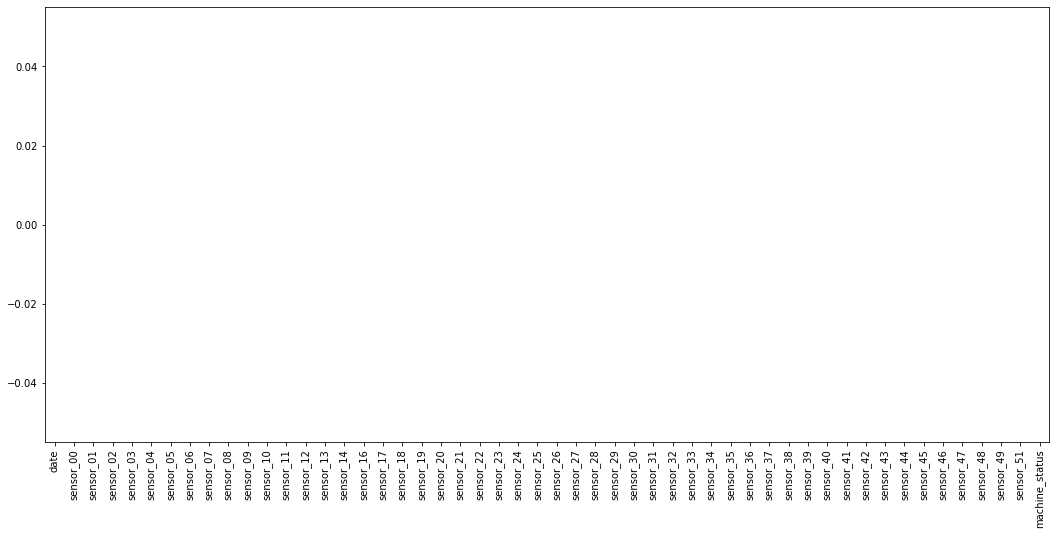

In [21]:
# Null value
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')

In [22]:
df.to_csv('sensor_fillna.csv')

In [23]:
df['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

### Divide df into Normal and Abnormal data

In [24]:
normal_df = df[df['machine_status']=='NORMAL']
abnormal_df = df[df['machine_status']!='NORMAL'] # BROKEN or RECOVERING

In [25]:
normal_df.head()

,date,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL


In [26]:
abnormal_df.head()

,date,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
17155,2018-04-12 21:55:00,0.0,53.34201,52.82118,43.402775,202.526031,49.79289,3.219039,16.89091,16.869210,...,36.979160,50.78125,50.92593,51.21528,50.63657,46.00694,409.1435,121.5278,324.6528,BROKEN
17156,2018-04-12 21:56:00,0.0,53.55902,52.77777,43.402775,204.725098,53.74214,3.045428,17.42621,15.740740,...,36.979164,49.47916,50.34722,51.21528,49.18982,49.47917,431.7130,133.1019,341.7245,RECOVERING
17157,2018-04-12 21:57:00,0.0,53.55902,52.77777,43.402775,201.137131,52.49996,7.537616,13.53443,9.324364,...,36.979160,48.17708,49.76852,50.92593,48.03241,53.81944,451.3889,140.0463,466.1458,RECOVERING
17158,2018-04-12 21:58:00,0.0,52.77777,52.69097,43.402770,204.030655,57.19875,7.609953,16.60880,16.203700,...,36.718750,46.87500,48.03241,50.34722,47.45370,58.15972,466.4352,144.9653,366.0301,RECOVERING
17159,2018-04-12 21:59:00,0.0,52.60416,52.73437,43.446180,203.567688,50.96181,7.573785,16.70284,16.160300,...,36.718750,45.83333,47.45370,49.76852,46.58565,63.65741,474.8264,149.0162,374.4213,RECOVERING


In [27]:
# Since the data is time series and the input is a window of certain size, we do not use shuffle here.
# normal df -> training : parameter setting : validation : test data ratio = 7:1:1:1

interval_n = int(len(normal_df)/10)
normal_df1 = df.iloc[0:interval_n*7]
normal_df2 = df.iloc[interval_n*7:interval_n*8]
normal_df3 = df.iloc[interval_n*8:interval_n*9]
normal_df4 = df.iloc[interval_n*9:]

## abnormal data -> validation : test = 5:5
interval_ab = int(len(abnormal_df)/2)
abnormal_df1 = df.iloc[0:interval_ab]
abnormal_df2 = df.iloc[interval_ab:]

In [28]:
# mean and var for data normalization

mean_df = normal_df1.mean()
std_df = normal_df1.std()

/tmp/ipykernel_398/10198925.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_df = normal_df1.mean()
/tmp/ipykernel_398/10198925.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_df = normal_df1.mean()
/tmp/ipykernel_398/10198925.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_df = normal_df1.std()


In [29]:
mean_df

sensor_00      2.159035
sensor_01     47.237951
sensor_02     50.527273
sensor_03     43.111523
sensor_04    569.103892
sensor_05     74.361346
sensor_06     12.473137
sensor_07     14.909206
sensor_08     14.364763
sensor_09     14.089501
sensor_10     39.231426
sensor_11     37.703331
sensor_12     26.699501
sensor_13      3.433757
sensor_14    355.188157
sensor_16    392.963155
sensor_17    399.775258
sensor_18      2.183312
sensor_19    552.852657
sensor_20    341.437981
sensor_21    753.720049
sensor_22    421.972289
sensor_23    836.447827
sensor_24    521.700664
sensor_25    608.041134
sensor_26    729.656096
sensor_27    468.764279
sensor_28    862.935752
sensor_29    594.106294
sensor_30    565.390382
sensor_31    833.293293
sensor_32    751.982607
sensor_33    470.463550
sensor_34    205.845316
sensor_35    370.890102
sensor_36    484.618437
sensor_37     80.523766
sensor_38     49.305332
sensor_39     37.284933
sensor_40     63.475283
sensor_41     35.847711
sensor_42     35

In [30]:
std_df = std_df[1:].astype(np.float64)
std_df

sensor_00      0.761847
sensor_01      3.745298
sensor_02      4.413519
sensor_03      2.709069
sensor_04    171.989881
sensor_05     20.696757
sensor_06      3.349412
sensor_07      3.940253
sensor_08      3.656255
sensor_09      3.571499
sensor_10     14.049191
sensor_11     13.998450
sensor_12     11.161769
sensor_13      4.648843
sensor_14    134.066602
sensor_16    149.744173
sensor_17    155.058150
sensor_18      0.915940
sensor_19    235.903058
sensor_20    120.547145
sensor_21    268.446801
sensor_22    178.366741
sensor_23    326.096578
sensor_24    215.784872
sensor_25    261.263688
sensor_26    280.200202
sensor_27    163.002204
sensor_28    361.501609
sensor_29    275.751421
sensor_30    224.414794
sensor_31    338.166005
sensor_32    291.078176
sensor_33    181.997764
sensor_34     85.520911
sensor_35    144.873657
sensor_36    299.936189
sensor_37     28.250875
sensor_38     11.692412
sensor_39     17.453755
sensor_40     21.010711
sensor_41      8.708935
sensor_42     12

### Dataset Structure

In [31]:
# Use index when calling the data.

def make_data_idx(dates, window_size=1):
    input_idx = []
    for idx in range(window_size-1, len(dates)):
        cur_date = dates[idx].to_pydatetime()
        in_date = dates[idx - (window_size-1)].to_pydatetime()
        
        _in_period = (cur_date - in_date).days * 24 * 60 + (cur_date - in_date).seconds / 60
        
        # Check whether each index is 1 minute.
        if _in_period == (window_size-1):
            input_idx.append(list(range(idx - window_size+1, idx+1)))
    return input_idx

In [32]:
## Compose TagDataset by inheriting Dataset

class TagDataset(Dataset):
    def __init__(self, input_size, df, mean_df=None, std_df=None, window_size=1):
        
        # Number of variables
        self.input_size = input_size
        
        # Length of sequence to be recovered
        self.window_size = window_size
        
        # Deep copy of the data for summary
        original_df = df.copy()
        
        # Normalization
        if mean_df is not None and std_df is not None:
            sensor_columns = [item for item in df.columns if 'sensor_' in item]
            df[sensor_columns] = (df[sensor_columns].astype(np.float64)-mean_df.astype(np.float64))/std_df.astype(np.float64)
        
        # Use continuous indices
        dates = list(df['date'])
        self.input_ids = make_data_idx(dates, window_size=window_size)
        
        # Make sure: Only use sensor data for reconstruction
        self.selected_column = [item for item in df.columns if 'sensor_' in item][:input_size]
        print(df[self.selected_column].values.dtype)
        self.var_data = torch.tensor(torch.from_numpy(df[self.selected_column].values.astype(np.float64)), dtype=torch.float)
        
        # For summary
        self.df = original_df.iloc[np.array(self.input_ids)[:, -1]]
        
    # Dataset은 반드시 __len__ 함수를 만들어줘야함(데이터 길이)
    def __len__(self):
        return len(self.input_ids)
    
    # Dataset은 반드시 __getitem__ 함수를 만들어줘야함
    # torch 모듈은 __getitem__ 을 호출하여 학습할 데이터를 불러옴.
    def __getitem__(self, item):
        temp_input_ids = self.input_ids[item]
        input_values = self.var_data[temp_input_ids]
        return input_values

### Modelling

In [33]:
class Encoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)|
        return (hidden, cell)
    
class Decoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        output, (hidden, cell) = self.lstm(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        prediction = self.fc(output)

        return prediction, (hidden, cell)
    
# LSTM Auto Encoder
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 window_size: int=1,
                 **kwargs) -> None:

        super(LSTMAutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.window_size = window_size

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1

        self.encoder = Encoder(
            input_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_dim,
            output_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )

    def forward(self, src:torch.Tensor, **kwargs):
        batch_size, sequence_length, var_length = src.size()

        ## Encoder 넣기
        encoder_hidden = self.encoder(src)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, src]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        
        ## MSE loss(Mean squared Error)
        loss = F.mse_loss(recons, input)
        return loss

### Training

In [34]:
def run(args, model, train_loader, test_loader):
    # optimizer setting
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    # training
    count = 0
    best_loss = 100000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            loss = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                
                batch_data = batch_data.to(args.device)
                predict_values = model(batch_data)
                loss = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        if eval_loss < best_loss:
            best_loss = eval_loss
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

def get_loss_list(args, model, test_loader):
    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
    loss_list = []
    
    with torch.no_grad():
        for i, batch_data in test_iterator:
                
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            
            # MAE(Mean Absolute Error)
            loss = F.l1_loss(predict_values[0], predict_values[1], reduce=False)
            
            # loss = loss.sum(dim=2).sum(dim=1).cpu().numpy()
            loss = loss.mean(dim=1).cpu().numpy()
            loss_list.append(loss)
    loss_list = np.concatenate(loss_list, axis=0)
    return loss_list

### Model and Paramter Setting

In [35]:
args = easydict.EasyDict({
    "batch_size": 128,
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    "input_size": 40,
    "latent_size": 10,
    "output_size": 40,
    "window_size" : 3, # sequence length
    "num_layers": 2, # number of LSTM layer
    "learning_rate" : 0.001,
    "max_iter" : 100000,
    'early_stop' : False
    })

### Model Training

In [36]:
# Convert to TagDataset

normal_dataset1 = TagDataset(df=normal_df1, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset2 = TagDataset(df=normal_df2, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset3 = TagDataset(df=normal_df3, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset4 = TagDataset(df=normal_df4, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
abnormal_dataset1 = TagDataset(df=abnormal_df1, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
abnormal_dataset2 = TagDataset(df=abnormal_df2, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)

/tmp/ipykernel_398/167534451.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_columns] = (df[sensor_columns].astype(np.float64)-mean_df.astype(np.float64))/std_df.astype(np.float64)


float64


/tmp/ipykernel_398/167534451.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.var_data = torch.tensor(torch.from_numpy(df[self.selected_column].values.astype(np.float64)), dtype=torch.float)
/tmp/ipykernel_398/167534451.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_columns] = (df[sensor_columns].astype(np.float64)-mean_df.astype(np.float64))/std_df.astype(np.float64)


float64


/tmp/ipykernel_398/167534451.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.var_data = torch.tensor(torch.from_numpy(df[self.selected_column].values.astype(np.float64)), dtype=torch.float)
/tmp/ipykernel_398/167534451.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_columns] = (df[sensor_columns].astype(np.float64)-mean_df.astype(np.float64))/std_df.astype(np.float64)


float64


/tmp/ipykernel_398/167534451.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.var_data = torch.tensor(torch.from_numpy(df[self.selected_column].values.astype(np.float64)), dtype=torch.float)
/tmp/ipykernel_398/167534451.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_columns] = (df[sensor_columns].astype(np.float64)-mean_df.astype(np.float64))/std_df.astype(np.float64)


float64
float64


/tmp/ipykernel_398/167534451.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.var_data = torch.tensor(torch.from_numpy(df[self.selected_column].values.astype(np.float64)), dtype=torch.float)
/tmp/ipykernel_398/167534451.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_columns] = (df[sensor_columns].astype(np.float64)-mean_df.astype(np.float64))/std_df.astype(np.float64)
/tmp/ipykernel_398/167534451.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torc

float64


/tmp/ipykernel_398/167534451.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.var_data = torch.tensor(torch.from_numpy(df[self.selected_column].values.astype(np.float64)), dtype=torch.float)


In [37]:
total_dataset = TagDataset(df=df, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)

float64


/tmp/ipykernel_398/167534451.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.var_data = torch.tensor(torch.from_numpy(df[self.selected_column].values.astype(np.float64)), dtype=torch.float)


In [38]:
# Convert to Data Loader

train_loader = torch.utils.data.DataLoader(
                 dataset=normal_dataset1,
                 batch_size=args.batch_size,
                 shuffle=True)
valid_loader = torch.utils.data.DataLoader(
                dataset=normal_dataset2,
                batch_size=args.batch_size,
                shuffle=False)

In [39]:
# Model generation

model = LSTMAutoEncoder(input_dim=args.input_size, latent_dim=args.latent_size, window_size=args.window_size, num_layers=args.num_layers)
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(40, 10, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(40, 10, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=10, out_features=40, bias=True)
  )
)

In [40]:
# Training epochs
model = run(args, model, train_loader, valid_loader)

  0%|          | 0/89 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

### Reconstruction Error - Mean and Covariance

In [41]:
# Get loss

loss_list = get_loss_list(args, model, valid_loader)

testing:   0%|          | 0/161 [00:00<?, ?it/s]

/home/ados/anaconda3/envs/torch191/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [42]:
# Reconstruction Error -> Mean and Covarinace

mean = np.mean(loss_list, axis=0)
std = np.cov(loss_list.T)

In [43]:
## Anomaly Score

class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        assert mean.shape[0] == std.shape[0] and mean.shape[0] == std.shape[1], 'Mean and Covariance should have same dimension.'
        self.mean = mean
        self.std = std
    
    def __call__(self, recons_error:np.array):
        x = (recons_error-self.mean)
        return np.matmul(np.matmul(x, self.std), x.T)

# Anomaly score calculator

anomaly_calculator = Anomaly_Calculator(mean, std)

In [44]:
# Find threshold

anomaly_scores = []
for temp_loss in tqdm(loss_list):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

print("Mean[{}], Median[{}], Minimum[{}], Maximum[{}]".format(np.mean(anomaly_scores), np.median(anomaly_scores), np.min(anomaly_scores), np.max(anomaly_scores)))

  0%|          | 0/20581 [00:00<?, ?it/s]

Mean[0.06813495075449075], Median[0.03707289241545797], Minimum[0.003499937382231131], Maximum[19.51057599180227]


### Data Visualization

In [45]:
anomaly_calculator = Anomaly_Calculator(mean, std)

In [46]:
total_dataset = TagDataset(df=df, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
total_dataloader = torch.utils.data.DataLoader(dataset=total_dataset,batch_size=args.batch_size,shuffle=False)

# Compute Reconstruction Loss
total_loss = get_loss_list(args, model, total_dataloader)

# Compute Anomaly Score

anomaly_scores = []
for temp_loss in tqdm(total_loss):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = total_dataset.df
visualization_df['score'] = anomaly_scores
visualization_df['recons_error'] = total_loss.sum(axis=1)

float64


/tmp/ipykernel_398/167534451.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.var_data = torch.tensor(torch.from_numpy(df[self.selected_column].values.astype(np.float64)), dtype=torch.float)


testing:   0%|          | 0/1722 [00:00<?, ?it/s]

/home/ados/anaconda3/envs/torch191/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/220318 [00:00<?, ?it/s]

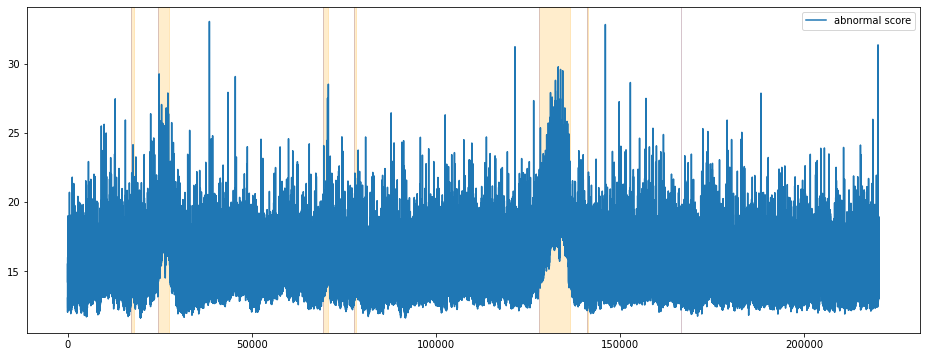

In [47]:
# Visualization

fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot(111)

# Abnormal Status

labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index


visualization_df['score'].plot(ax=ax)
ax.legend(['abnormal score'], loc='upper right')


temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha=0.2, color='orange')

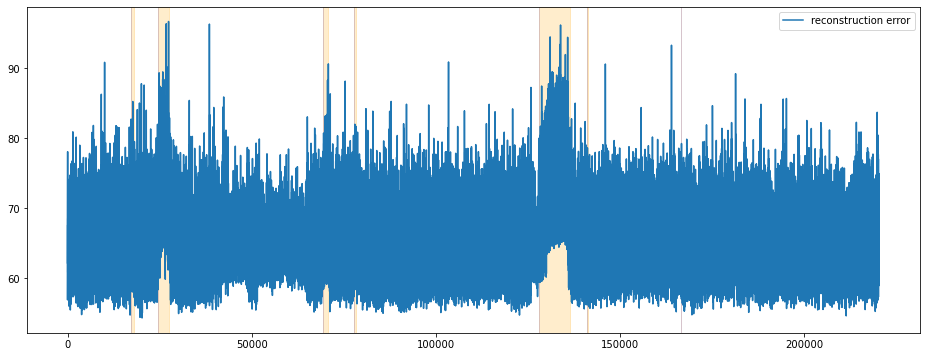

In [48]:
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot(111)

labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index

# Abnormal Status

visualization_df['recons_error'].plot(ax=ax)
ax.legend(['reconstruction error'], loc='upper right')

temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha=0.2, color='orange')